In [2]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np

np.random.seed(42)

In [3]:
'''The current annotations in the text files are in normalized `[x_center, y_center, width, height]` format.
    Let's write a function that will convert it back to `[x_min, y_min, x_max, y_max]` format to check these annotations'''

def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2] / 2, bboxes[1] - bboxes[3] / 2
    xmax, ymax = bboxes[0]+bboxes[2] / 2, bboxes[1] + bboxes[3] / 2
    return xmin, ymin, xmax, ymax

In [4]:
# Change this list to match your data.yaml file
class_names = ['Ambulance', 'Vehicle']

# This line now correctly creates 2 colors, one for each class
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

def yolo2bbox(box):
    # This is a placeholder function. You likely have this defined elsewhere.
    # It converts YOLO format [x_center, y_center, width, height]
    # to [x_min, y_min, x_max, y_max]
    x, y, w, h = box
    x1, y1 = x - w/2, y - h/2
    x2, y2 = x + w/2, y + h/2
    return x1, y1, x2, y2

def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        
        # denormalize the coordinates
        xmin = int(x1 * w)
        ymin = int(y1 * h)
        xmax = int(x2 * w)
        ymax = int(y2 * h)
        
        # This line will now work correctly with your model's output (0 or 1)
        class_name = class_names[int(labels[box_num])]
        
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        ) 

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))
        
        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        
        # Text width and height
        tw, th = cv2.getTextSize(class_name, 0, fontScale=font_scale, thickness=font_thickness)[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image, 
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image, 
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [5]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()
    
    num_images = len(all_training_images)
    
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

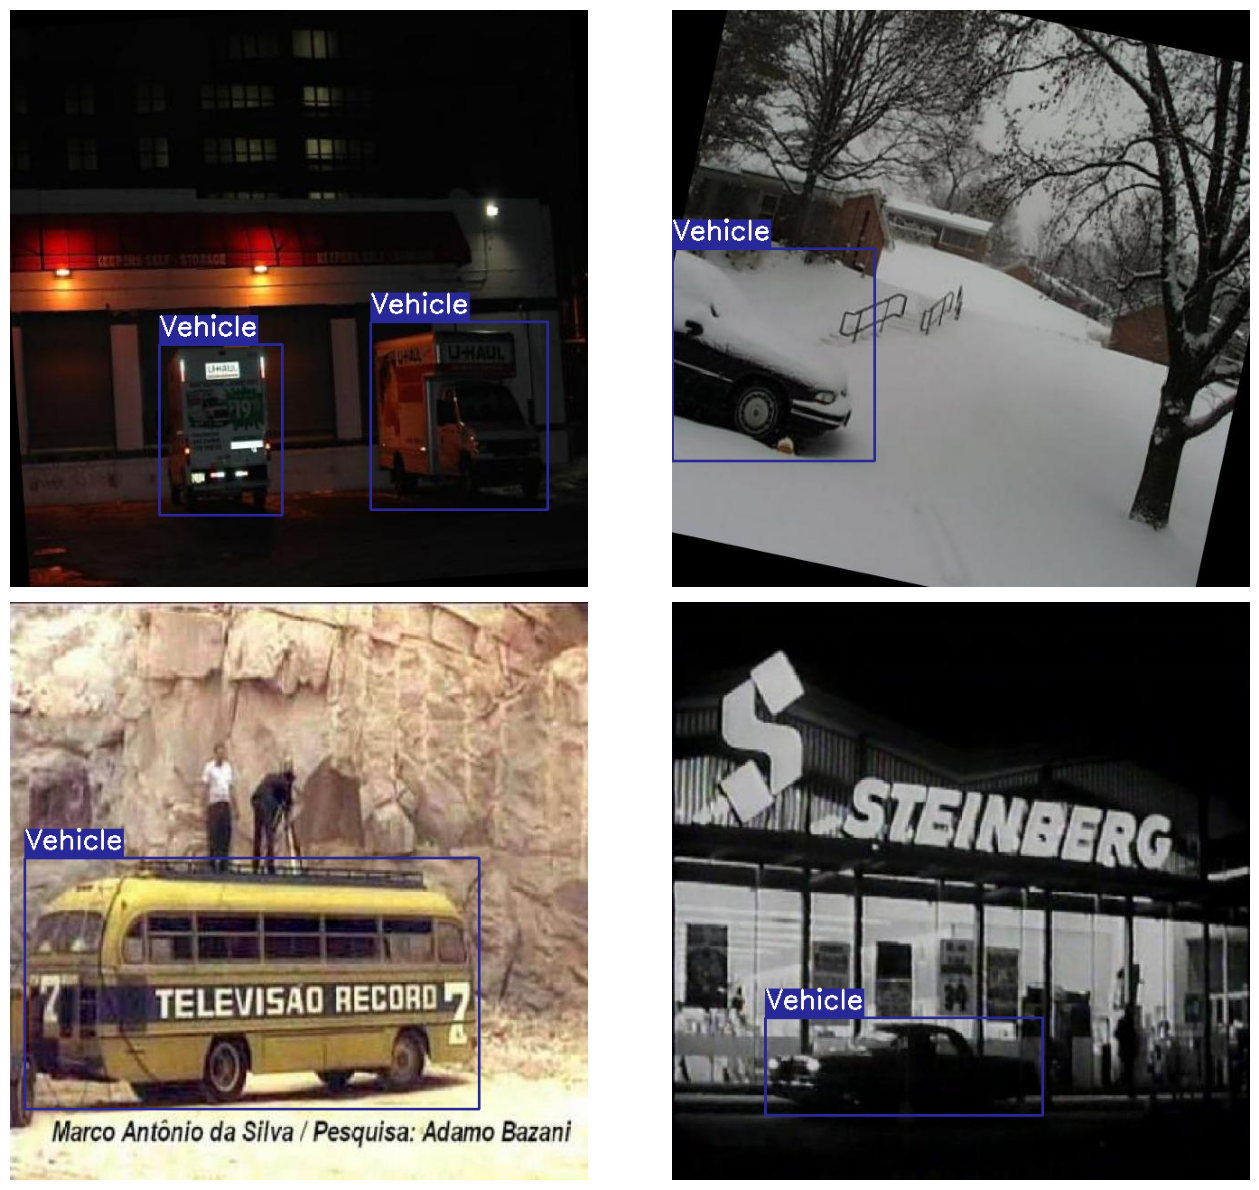

In [6]:
plot(image_paths="/kaggle/input/amb-veh-yolo/Combined_dataset/train/images/*",
     label_paths="/kaggle/input/amb-veh-yolo/Combined_dataset/train/labels/*",
     num_samples=4)

In [7]:
import torch

def verify_gpu():
    """
    Checks if a CUDA-enabled GPU is available and prints its details.
    Ultralytics' YOLO automatically uses the GPU if it's available.
    """
    print("--- GPU Verification ---")
    try:
        if torch.cuda.is_available():
            gpu_count = torch.cuda.device_count()
            print(f"✅ Success! Found {gpu_count} CUDA-enabled GPU(s).")
            for i in range(gpu_count):
                gpu_name = torch.cuda.get_device_name(i)
                print(f"  - GPU {i}: {gpu_name}")
            print(f"Ultralytics will automatically use: {torch.cuda.get_device_name(0)}")
        else:
            print("⚠️ Warning: No CUDA-enabled GPU found.")
            print("Training will proceed on the CPU, which will be significantly slower.")
    except Exception as e:
        print(f"An error occurred while checking for the GPU: {e}")
    finally:
        print("----------------------\n")

verify_gpu()

--- GPU Verification ---
✅ Success! Found 2 CUDA-enabled GPU(s).
  - GPU 0: Tesla T4
  - GPU 1: Tesla T4
Ultralytics will automatically use: Tesla T4
----------------------



In [8]:
!pip install ultralytics

In [9]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLO11n model
model = YOLO("yolo11n.pt")

In [10]:
import yaml

# Define the dataset configuration with the FULL, correct path
# Note the addition of 'yolo-dataset' to the path
dataset_config = {
    'path': '/kaggle/input/amb-veh-yolo/Combined_dataset',
    'train': 'train',  # Images are directly in the 'train' folder
    'val': 'valid',      # Images are directly in the 'val' folder
    'test': 'test',    # Images are directly in the 'test' folder
    'nc': 2,
    'names': ['Ambulance', 'Vehicle']
}

# Define the path for the new YAML file in the writable directory
yaml_file_path = '/kaggle/working/data.yaml'

# Write the configuration to the new YAML file
with open(yaml_file_path, 'w') as file:
    yaml.dump(dataset_config, file, default_flow_style=False)

print(f"Successfully created corrected {yaml_file_path}")

Successfully created corrected /kaggle/working/data.yaml


In [11]:
!cat /kaggle/working/data.yaml

names:
- Ambulance
- Vehicle
nc: 2
path: /kaggle/input/amb-veh-yolo/Combined_dataset
test: test
train: train
val: valid


In [12]:
!ls /kaggle/input/

amb-veh-yolo


In [13]:
results = model.train(data="/kaggle/working/data.yaml", epochs=100, imgsz=640)

Ultralytics 8.3.191 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        212        427      0.937      0.862      0.917      0.798
             Ambulance         31         47       0.99      0.957      0.985      0.919
               Vehicle        181        380      0.885      0.766      0.849      0.678
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/train4


In [14]:
metrics = model.val()

Ultralytics 8.3.191 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 2.5±2.3 ms, read: 92.5±32.3 MB/s, size: 60.2 KB)
val: Scanning /kaggle/input/amb-veh-yolo/Combined_dataset/valid/labels... 212 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 212/212 595.0it/s 0.4s0.1s
WARNING ⚠️ val: Cache directory /kaggle/input/amb-veh-yolo/Combined_dataset/valid is not writeable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 14/14 4.5it/s 3.1s0.1s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        212        427      0.943      0.862      0.918      0.798
             Ambulance         31         47      0.991      0.957      0.985      0.918
               Vehicle        181        380      0.895      0.766      0.851      0.677
Speed: 1.8ms preprocess, 5.1ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/train42


In [16]:
!yolo task=detect mode=predict model=/kaggle/working/runs/detect/train4/weights/best.pt source='/kaggle/input/amb-veh-yolo/Combined_dataset/test/images/ds1_011a8a0a921c2376_jpg.rf.f393bc172b737dd08f8b93ac9a2caf31.jpg'

Ultralytics 8.3.191 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs

image 1/1 /kaggle/input/amb-veh-yolo/Combined_dataset/test/images/ds1_011a8a0a921c2376_jpg.rf.f393bc172b737dd08f8b93ac9a2caf31.jpg: 640x640 1 Vehicle, 40.8ms
Speed: 3.6ms preprocess, 40.8ms inference, 168.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


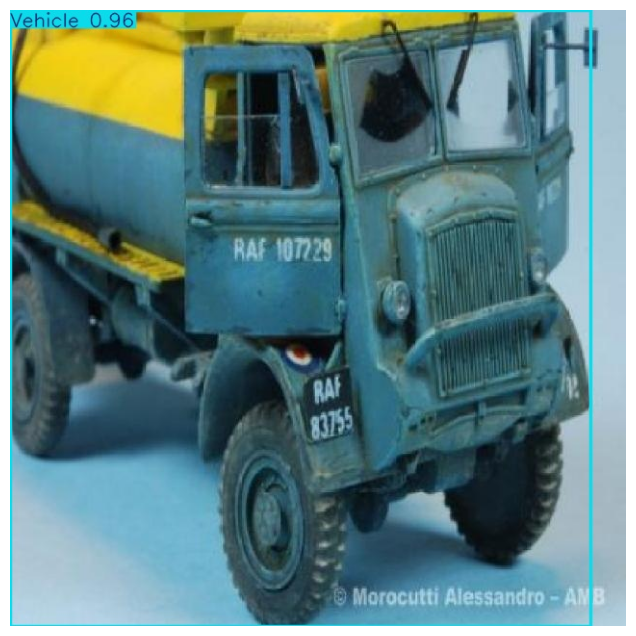

In [18]:
img_path = '/kaggle/working/runs/detect/predict/ds1_011a8a0a921c2376_jpg.rf.f393bc172b737dd08f8b93ac9a2caf31.jpg'
img = plt.imread(img_path)

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis(False)
plt.show()

In [20]:
import os

file_path = "/kaggle/working/my_outputs.zip"

if os.path.exists(file_path):
    os.remove(file_path)
    print("File deleted successfully.")
else:
    print("File not found.")


File deleted successfully.


In [22]:
import zipfile
import os

zip_path = "/kaggle/working/my_outputs.zip"

with zipfile.ZipFile(zip_path, 'w') as zipf:
    for root, _, files in os.walk("/kaggle/working"):
        for file in files:
            file_path = os.path.join(root, file)
            if file_path == zip_path:  # skip the zip itself
                continue
            zipf.write(file_path, arcname=os.path.relpath(file_path, "/kaggle/working"))
